# RF Power Spectra Attenuation

Attenuation is a measure of how the strength of a signal changes as it propagates through space. In the context of ultrasound imaging, an ultrasound acoustic waveform will reduce in intensity as it moves through tissue, often in different ways depending on the type of tissue. We can gain insights into the properties of objects in the viewing plane of an ultrasound probe by examining how reflected signals from the probe attenuate over time and space.

Ultrasound imaging works by repeatedly emitting ultrasound acoustic waves and then translating reflected waveforms into RF signals over a very short time. By transforming RF waveforms into the power frequency (Fourier) domain, we can selectively estimate how different signal frequencies lose strength as they propagate through tissue.

This notebook demonstrates how to use tools available in ITK and ITKUltrasound to generate attenuation estimations and get statistical insights. Sample data used in this notebook represents a 2D sweep over a liver volume, with the first image dimension the direction of RF waveforms, the second dimension representing the lateral direction along probe elements, and the third dimension representing steps in time. Each pixel itself represents estimated power spectra frequency content at the given point in space, with 31 bins representing the frequency range (0, nyquist_frequency). A mask is provided as an expert segmentation of the liver from the corresponding BMode image.

Please see `PlotPowerSpectra.ipynb` for an example visualizing 31-channel power spectra averaged across an image. `SpectralDistributions.ipynb` may also be referenced to demonstrate how a 31-channel power spectra image may be generated from an RF ultrasound image.

In [1]:
# Install notebook dependencies
import sys
#!{sys.executable} -m pip install itk itk-ultrasound matplotlib

In [2]:
import os
import requests
import shutil

import itk
import matplotlib.pyplot as plt
assert 'AttenuationImageFilter' in dir(itk) # Verify we have an up-to-date version of itk-ultrasound

## Retrieve and Load Spectra Data

In [3]:
SAMPLING_FREQUENCY_MHZ = 60.0
SCAN_DIRECTION = 0

In [4]:
# Retrieve hosted sample data from data.kitware.com

spectra_image_path = (('data/UnfusedRF-a0-spectra-cropped.mhd','https://data.kitware.com/api/v1/file/621902af4acac99f425ebe8b/download'),
                      ('data/UnfusedRF-a0-spectra-cropped.raw','https://data.kitware.com/api/v1/file/621902ae4acac99f425ebe73/download'))
mask_image_path = (('data/UnfusedRF-a0-spectra-label_1-cropped.mhd','https://data.kitware.com/api/v1/file/621902ae4acac99f425ebe7b/download'),
                   ('data/UnfusedRF-a0-spectra-label_1-cropped.raw','https://data.kitware.com/api/v1/file/621902af4acac99f425ebe83/download'))

os.makedirs('data',exist_ok=True)

for idx in range(2):
    if not os.path.exists(spectra_image_path[idx][0]):
        response = requests.get(spectra_image_path[idx][1], stream=True)
        with open(spectra_image_path[idx][0], 'wb') as fp:
            response.raw.decode_content = True
            shutil.copyfileobj(response.raw, fp)
        
for idx in range(2):
    if not os.path.exists(mask_image_path[idx][0]):
        response = requests.get(mask_image_path[idx][1], stream=True)
        with open(mask_image_path[idx][0], 'wb') as fp:
            response.raw.decode_content = True
            shutil.copyfileobj(response.raw, fp)

Sample has size itkSize3 ([96, 128, 10]) where dim0 = scanline, dim1 = lateral, dim2 = time
Samples has 31 frequency components


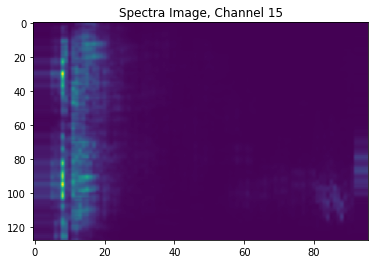

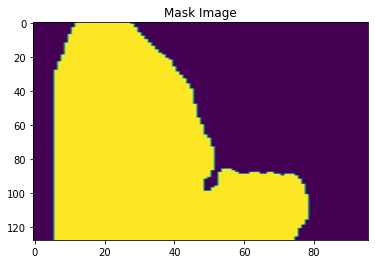

In [5]:
spectra_image = itk.imread(spectra_image_path[0][0],pixel_type=itk.VariableLengthVector[itk.F])
mask_image = itk.imread(mask_image_path[0][0])

print(f'Sample has size {itk.size(spectra_image)} where dim0 = scanline, dim1 = lateral, dim2 = time')
print(f'Samples has {spectra_image.GetNumberOfComponentsPerPixel()} frequency components')

time_idx = 9             # Arbitrarily pick timestep 9 out of 10 for viewing
frequency_bin_idx = 15   # Arbitrarily pick channel 15 out of 31 for viewing
plt.imshow(spectra_image[time_idx,:,:,frequency_bin_idx],aspect='auto')
plt.title(f'Spectra Image, Channel {frequency_bin_idx}')
plt.show()
plt.imshow(mask_image[time_idx,:,:],aspect='auto')
plt.title('Mask Image')
plt.show()

## Estimate Attenuation Within Liver Tissue

`itk.AttunationImageFilter` defines a procedure for estimating attenuation among points in the RF spectra image. Points are selected according to several criteria:
- Attenuation is estimated between two pixels in the spectra input image, a "source" and a "target"
- A "source" and "target" pair must occupy the same scan line
- Attenuation output is a scalar image with the same size, spacing, orientation, origin as the input spectra image
- Each output pixel corresponds to an input "source" pixel
- Attenuation estimation only takes place within an updated mask. Output pixels outside of the updated mask are fixed at zero.
- The updated mask is generated by taking the input image and eroding via "upper" and "lower" pad bounds
- If fixed estimation is zero (not set), the "target" pixel is selected by tracing along the scanline from the "source" pixel and taking the last pixel that lies within the updated mask.
- If fixed estimation is set, the "target" pixel is selected at a fixed depth along the scanline from the "source" pixel. If that "target" pixel lies outside the updated mask, the fixed estimation is ignored and the previously described method is used.

The output is an image of attenuation estimations.

In [6]:
metric_image_type = itk.Image[itk.F,spectra_image.GetImageDimension()]
attenuation_filter = itk.AttenuationImageFilter[type(spectra_image),metric_image_type].New()

attenuation_filter.SetInput(spectra_image)
attenuation_filter.SetInputMaskImage(mask_image)
attenuation_filter.SetSamplingFrequencyMHz(SAMPLING_FREQUENCY_MHZ)
attenuation_filter.SetScanDirection(SCAN_DIRECTION)

# Get attenuation within a confined frequency band
attenuation_filter.SetFrequencyBandStartMHz(5.0)
attenuation_filter.SetFrequencyBandEndMHz(20.0)

# Account for segmentation error by estimating attenuation starting from
# a fixed distance into the liver, essentially eroding the mask image
attenuation_filter.SetPadLowerBoundsMM(3.0)
attenuation_filter.SetPadUpperBoundsMM(3.0)

# Normalize by estimating at a fixed distance between pixels where possible
attenuation_filter.SetFixedEstimationDepthMM(3.0)

# Round up any apparent negative attenuations to zero
attenuation_filter.SetConsiderNegativeAttenuations(False)

attenuation_filter.Update()

Template itk::ImageToImageFilter<itk::Image<itk::Vector<float,2>,2>,itk::Image<itk::CovariantVector<float,2>,2>>
 already defined as <class 'itk.itkImageToImageFilterAPython.itkImageToImageFilterIVF22ICVF22'>
 is redefined as {cl}
Template itk::ImageToImageFilter<itk::Image<itk::Vector<float,3>,3>,itk::Image<itk::CovariantVector<float,3>,3>>
 already defined as <class 'itk.itkImageToImageFilterAPython.itkImageToImageFilterIVF33ICVF33'>
 is redefined as {cl}


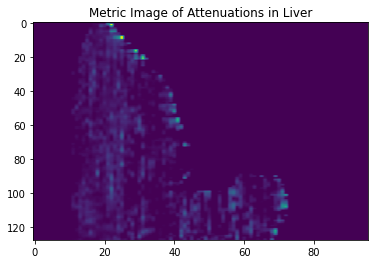

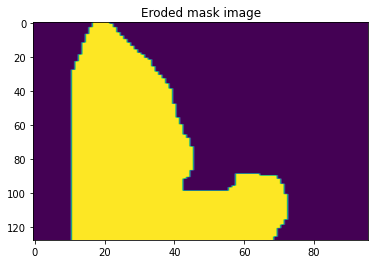

In [7]:
metric_image = attenuation_filter.GetOutput()
output_mask_image = attenuation_filter.GetOutputMaskImage()

plt.imshow(metric_image[time_idx,:,:], aspect='auto')
plt.title('Metric Image of Attenuations in Liver')
plt.show()

plt.imshow(output_mask_image[time_idx,:,:],aspect='auto')
plt.title('Eroded mask image')
plt.show()

## Get Attenuation Statistics

Attenuation estimates are subject to noise and can be highly variable. ITK statistics filters can be deployed to acquire useful information regarding the masked region of estimated attenuation samples.

In [8]:
statistics_filter = itk.LabelStatisticsImageFilter[type(metric_image),type(output_mask_image)].New()
statistics_filter.SetInput(metric_image)
statistics_filter.SetLabelInput(output_mask_image)
statistics_filter.Update()

print(f'Count:\t{statistics_filter.GetCount(1)}\n'
      f'Min:\t{statistics_filter.GetMinimum(1):0.4f}\tdB/(MHz*cm)\n'
      f'Max:\t{statistics_filter.GetMaximum(1):0.4f}\tdB/(MHz*cm)\n'
      f'Mean:\t{statistics_filter.GetMean(1):0.4f}\tdB/(MHz*cm)\n'
      f'Sigma:\t{statistics_filter.GetSigma(1):0.4f}\tdB/(MHz*cm)\n'
      f'Variance: {statistics_filter.GetVariance(1):0.4f} dB/(MHz*cm)\n'
      f'Sum:\t{statistics_filter.GetSum(1):0.2f} dB/(MHz*cm)\n'
      )

Count:	33722
Min:	0.0000	dB/(MHz*cm)
Max:	26.7213	dB/(MHz*cm)
Mean:	0.9046	dB/(MHz*cm)
Sigma:	1.3161	dB/(MHz*cm)
Variance: 1.7322 dB/(MHz*cm)
Sum:	30505.51 dB/(MHz*cm)



In [9]:
histogram_filter = itk.MaskedImageToHistogramFilter[type(metric_image),type(output_mask_image)].New()
histogram_filter.SetInput(metric_image)
histogram_filter.SetMaskImage(output_mask_image)
histogram_filter.SetMaskValue(1)
histogram_filter.SetHistogramSize([1e5])
histogram_filter.SetMarginalScale(10)
histogram_filter.Update()

histogram = histogram_filter.GetOutput()
size = histogram.GetSize(0)
print(f'Histogram size: {size} bins'
      f' from {histogram.GetBinMin(0,0)} dB/(MHz*cm)'
      f' to {histogram.GetBinMax(0,size-1):0.4f} dB/(MHz*cm)'
      f' with {histogram.GetTotalFrequency()} entries')

print(f'Histogram mean is {histogram.Mean(0):0.4f}')

print(f'{histogram.GetFrequency(0, 0)} entries in bin '
      f' from {histogram.GetBinMin(0,0)} dB/(MHz*cm)'
      f' to {histogram.GetBinMax(0,0):0.4f} dB/(MHz*cm)')
print(f'5th percentile: {histogram.Quantile(0,0.05):0.4f} dB/(MHz*cm)\n'
      f'25th percentile: {histogram.Quantile(0,0.25):0.4f} dB/(MHz*cm)\n'
      f'50th percentile: {histogram.Quantile(0,0.50):0.4f} dB/(MHz*cm)\n'
      f'75th percentile: {histogram.Quantile(0,0.75):0.4f} dB/(MHz*cm)\n'
      f'95th percentile: {histogram.Quantile(0,0.95):0.4f} dB/(MHz*cm)')

Histogram size: 100000 bins from 0.0 dB/(MHz*cm) to 26.7213 dB/(MHz*cm) with 33722 entries
Histogram mean is 0.9047
9295 entries in bin  from 0.0 dB/(MHz*cm) to 0.0003 dB/(MHz*cm)
5th percentile: 0.0000 dB/(MHz*cm)
25th percentile: 0.0002 dB/(MHz*cm)
50th percentile: 0.5667 dB/(MHz*cm)
75th percentile: 1.2394 dB/(MHz*cm)
95th percentile: 2.9658 dB/(MHz*cm)
